# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

<img src="https://github.com/oussamarhouch/Projet-Audio/blob/main/figure/model%20based.png?raw=1" alt="CS" style="width: 750px;"/>

### Import libraries

```python

In [1]:
import librosa
import librosa.display
import numpy as np
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import warnings
import logging
torch.cuda.empty_cache()
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from IPython.display import Audio

### load data

```python

##### zip files

In [2]:
# own IDE
zip_file_paths = ['data/data_part1.zip', 'data/data_part2.zip', 'data/data_part3.zip', 'data/data_part4.zip']

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# os.makedirs("data", exist_ok=True)

# zip_file_paths = ['/content/drive/My Drive/audio_project/data_part1.zip',
#     '/content/drive/My Drive/audio_project/data_part2.zip',
#     '/content/drive/My Drive/audio_project/data_part3.zip',
#     '/content/drive/My Drive/audio_project/data_part4.zip']

##### unzip files

In [3]:
for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

##### data folders

In [4]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

##### audio duration

In [5]:
target_duration = 4 # 4sec

##### clean path

In [6]:
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

##### clean data

In [7]:
clean_data = []
for clean_file in clean_path[:1000]:
    s, sr = librosa.load(clean_file, sr=16000)
    target_length = target_duration * sr
    s = librosa.util.fix_length(s, size = target_length)
    clean_data.append(s)

##### noise data

In [8]:
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

### Data exploration

```python

#### Clean audio

##### write clean audio

In [9]:
s_rate = 16000

write("clean.wav", s_rate, s)

##### Read clean Audio

In [10]:
Audio("clean.wav")

##### normalize clean audio

In [11]:
s_norm = preprocessing.normalize(s.reshape(1, -1), norm='max')

##### scale clean audio

In [12]:
s_scale = scale(s_norm, axis=1, with_mean=True, with_std=True, copy=True)

##### Fourier transform of clean audio

In [13]:
s_fft = librosa.stft(s_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

##### Convert to spectrogram

In [14]:
s_db = librosa.amplitude_to_db(np.abs(s_fft), ref=np.max)

#### Noise audio

##### read noise audio

In [15]:
u, ur = librosa.load(noise_file, sr=16000)

##### adjust noise audio length

In [16]:
target_length = target_duration * ur
u = librosa.util.fix_length(u, size = target_length)

##### Write noise audio

In [17]:
write("noise.wav", ur, u)

##### Read noise audio

In [18]:
Audio("noise.wav")

##### Normalize noise audio

In [19]:
u_norm = preprocessing.normalize(u.reshape(1, -1), norm='max')

##### Scale noise audio

In [20]:
u_scale = scale(u_norm, axis=1, with_mean=True, with_std=True, copy=True)

##### Fourier transform of noise audio

In [21]:
u_fft = librosa.stft(u_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

##### Convert to spectrogram

In [22]:
u_db = librosa.amplitude_to_db(np.abs(u_fft))

#### Noisy audio

##### ratio signal to noise

In [23]:
rsb = 6
alpha = 10**(-rsb/10)

##### Create noisy audio

In [24]:
x = s + alpha * u[:len(s)]

##### Write noisy audio

In [25]:
write(os.path.join('', "mixed.wav"), s_rate, x)

##### Read noisy audio

In [26]:
Audio(os.path.join('', "mixed.wav"))

##### Normalize noisy audio

In [27]:
x_norm = preprocessing.normalize(x.reshape(1, -1), norm='max')

##### Scale noisy audio

In [28]:
x_scale = scale(x_norm, axis=1, with_mean=True, with_std=True, copy=True)

##### Fourier transform of noisy audio

In [29]:
x_fft = librosa.stft(x_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

##### Convert to spectrogram

In [30]:
x_db = librosa.amplitude_to_db(np.abs(x_fft))

### Data Manipulation
    
```python   

##### l2 norm

In [31]:
s_l2 = np.linalg.norm(s_fft, ord=1, axis=0, keepdims=True)
u_l2= np.linalg.norm(u_fft, ord=1, axis=0, keepdims=True)
x_l2 = np.linalg.norm(x_fft, ord=2, axis=0, keepdims=True)

##### Normalize fourier transforma

In [32]:
s_norm = s_fft / s_l2 + 1e-8
u_norm = u_fft / u_l2 + 1e-8
x_norm = x_fft / x_l2 + 1e-8

##### Mask computation

In [33]:
mask = np.where(np.abs(s_norm ** 2) > np.abs(u_norm ** 2), 1, 0)

##### logarithmic scale

In [34]:
log_noisy = np.log1p(np.abs(x_norm))

##### Apply mask

In [35]:
masked_x_fft = mask * x_fft

##### Inverse fourier transform

In [36]:
masked_x = librosa.istft(masked_x_fft, hop_length=256, win_length=512, window='hamming', center=True, length=len(s))
masked_x = masked_x / np.max(np.abs(masked_x))

##### Write cleaned audio

In [37]:
write(os.path.join(denoising_folder, "denoised_" + str(8) + ".wav"), s_rate, masked_x.astype(np.float32))

##### Read cleaned audio

In [38]:
Audio(os.path.join(denoising_folder, "denoised_" + str(8) + ".wav"))

##### Plot of curves

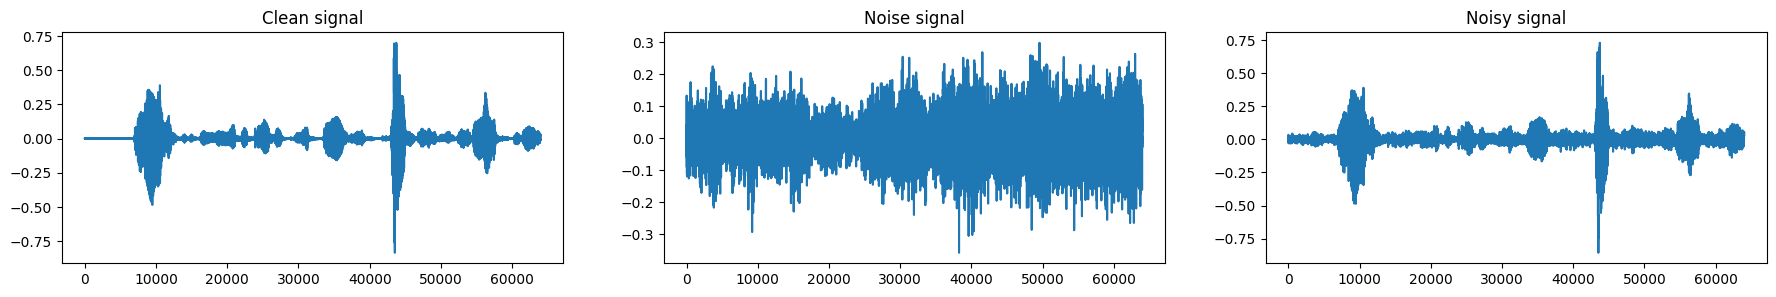

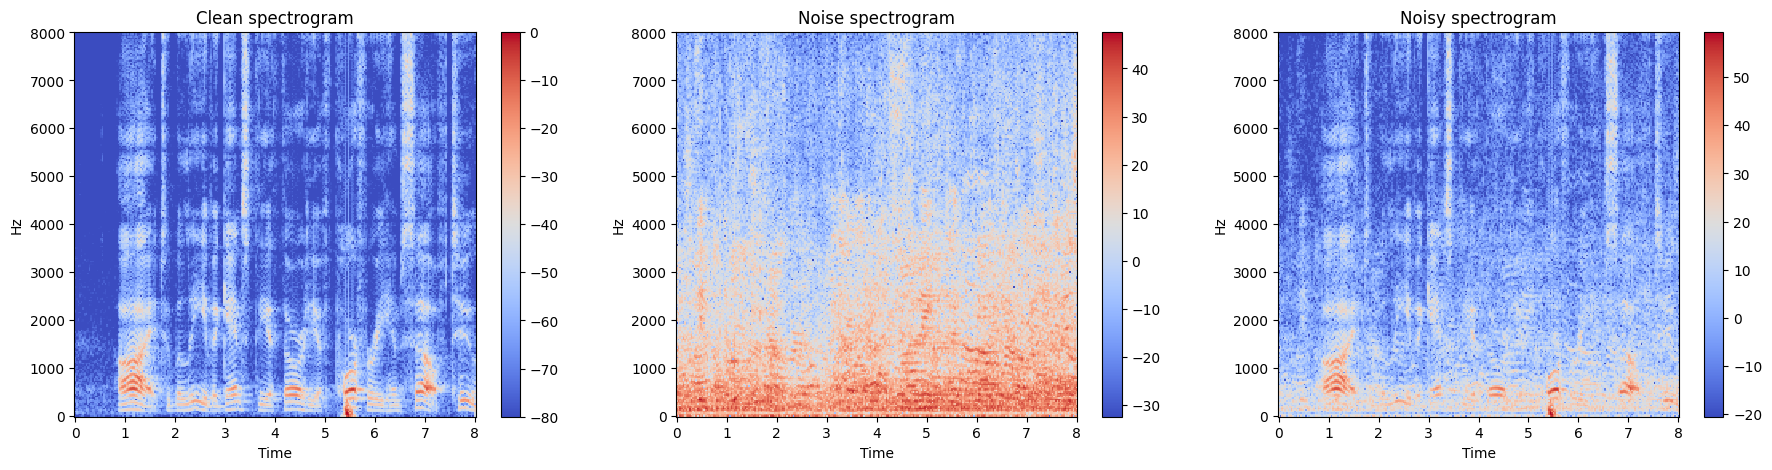

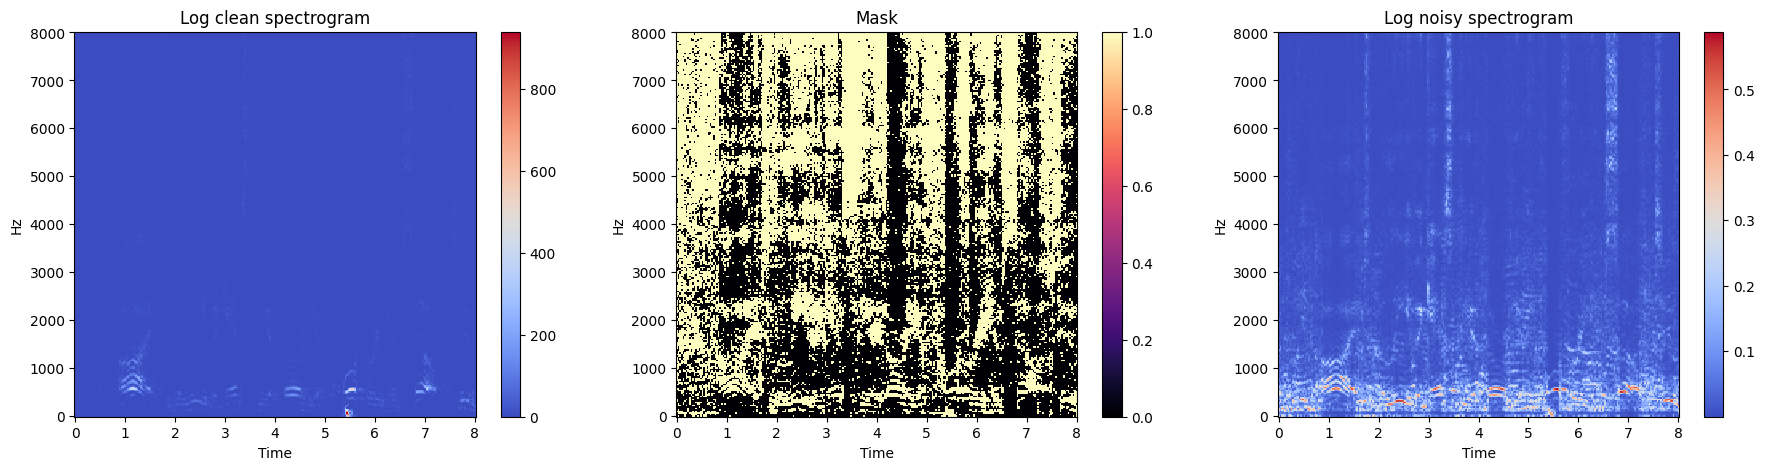

In [39]:
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
plt.plot(s)
plt.title("Clean signal")
plt.subplot(1, 3, 2)
plt.plot(u)
plt.title("Noise signal")
plt.subplot(1, 3, 3)
plt.plot(x)
plt.title("Noisy signal")
plt.show()

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(s_db, sr=s_rate, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title("Clean spectrogram")
plt.subplot(1, 3, 2)
librosa.display.specshow(u_db, sr=s_rate, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title("Noise spectrogram")
plt.subplot(1, 3, 3)
librosa.display.specshow(x_db, sr=s_rate, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title("Noisy spectrogram")
plt.show()

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(masked_x_fft, sr=s_rate, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title("Log clean spectrogram")
plt.subplot(1, 3, 2)
librosa.display.specshow(mask, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Mask")

# Second subplot
plt.subplot(1, 3, 3)
librosa.display.specshow(log_noisy, sr=s_rate, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title("Log noisy spectrogram")

plt.show()


### Preprocessing

```python

##### Dataset class

In [40]:
class AudioDataset(Dataset):
    def __init__(self, clean_data, noise_file, rsb):
        self.clean_data = clean_data
        self.noise_file = noise_file
        self.masks = []
        self.log_noisy_spec = []
        self.rsb = rsb

    def __len__(self):
        return len(self.clean_data)

    def process(self):
        for idx in range(len(self.clean_data)):
            s = self.clean_data[idx]
            u, ur = librosa.load(self.noise_file, sr=16000)
            target_length = len(s)
            u = librosa.util.fix_length(u, size = target_length)
            alpha = 10**(-self.rsb/10)
            x = s + alpha * u[:len(s)]
            
            # save noisy file
            write(os.path.join(output_folder, "noisy_" + str(idx) + ".wav"), s_rate, x)
        
            # fourier transform
            s_fft = librosa.stft(s, n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')
            u_fft = librosa.stft(u, n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')
            x_fft = librosa.stft(x, n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')           
            
            # normalize the data
            s_l2 = np.linalg.norm(s_fft, ord=2, axis=0, keepdims=True)
            u_l2 = np.linalg.norm(u_fft, ord=2, axis=0, keepdims=True)
            x_l2 = np.linalg.norm(x_fft, ord=2, axis=0, keepdims=True)
            
            s_norm = s_fft / s_l2 + 1e-8
            u_norm = u_fft / u_l2 + 1e-8
            x_norm = x_fft / x_l2 + 1e-8
            
            # change to torch
            x_norm = torch.from_numpy(x_norm)
            
            mask = np.where(np.abs(s_norm) > np.abs(u_norm), 1, 0)
            mask = torch.from_numpy(mask)         
            
            log_noisy = torch.log1p(torch.abs(x_norm))
            
            self.masks.append(mask)
            self.log_noisy_spec.append(log_noisy)
            
    def __getitem__(self, idx):
        return self.masks[idx], self.log_noisy_spec[idx]

##### Dataset Creation

In [41]:
dataset = AudioDataset(clean_data, noise_file, rsb=6) 
dataset.process()

### Deep Learning Model

```python

##### Network architecture

In [42]:
class CNN(nn.Module):
    def __init__(self, hidden_size, kernel_size, stride, padding):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv6 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv7 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv8 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv9 = nn.Conv2d(in_channels=hidden_size, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.sigmoid(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.sigmoid(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.sigmoid(self.conv9(x))
        return x

##### Model definition

In [43]:
model = CNN(hidden_size=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).cuda()

##### Model Optimizer

In [44]:
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Model Summary

In [45]:
summary(model, input_size=(1, 257, 126))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 257, 126]           1,280
              ReLU-2        [-1, 128, 257, 126]               0
            Conv2d-3        [-1, 128, 257, 126]         147,584
              ReLU-4        [-1, 128, 257, 126]               0
            Conv2d-5        [-1, 128, 257, 126]         147,584
           Sigmoid-6        [-1, 128, 257, 126]               0
            Conv2d-7        [-1, 128, 257, 126]         147,584
              ReLU-8        [-1, 128, 257, 126]               0
            Conv2d-9        [-1, 128, 257, 126]         147,584
          Sigmoid-10        [-1, 128, 257, 126]               0
           Conv2d-11        [-1, 128, 257, 126]         147,584
             ReLU-12        [-1, 128, 257, 126]               0
           Conv2d-13        [-1, 128, 257, 126]         147,584
          Sigmoid-14        [-1, 128, 2

##### Train loader

In [46]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

##### Model training

In [47]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (masks, log_noisy_spec) in enumerate(train_loader):
        masks = masks.float()
        log_noisy_spec = log_noisy_spec.float()
        masks = masks.cuda()
        log_noisy_spec = log_noisy_spec.cuda()
        optimizer.zero_grad()
        outputs = model(log_noisy_spec.unsqueeze(1))
        loss = criteria(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [10/32], Loss: 0.2376


##### Model evaluation

In [ ]:
# model testing
model.eval()

losses = []

with torch.no_grad():
    for i, (masks, log_noisy_spec) in enumerate(train_loader):
        masks = masks.float()
        log_noisy_spec = log_noisy_spec.float()
        masks = masks.cuda()
        log_noisy_spec = log_noisy_spec.cuda()
        outputs = model(log_noisy_spec.unsqueeze(1))
        loss = criteria(outputs, masks.unsqueeze(1))
        losses.append(loss.item())
        if (i+1) % 10 == 0:
            print('Step [{}/{}], Loss: {:.4f}'.format(i+1, len(train_loader), loss.item()))
            
print("Average loss: {:.4f}".format(np.mean(losses)))

Step [10/20], Loss: 0.2396
Step [20/20], Loss: 0.2442
Average loss: 0.2423


In [ ]:
# save model
torch.save(model.state_dict(), "model.pt")

In [ ]:
x_fft = x_fft
mask = mask

log_noisy_tensor = torch.from_numpy(log_noisy).float().cuda()

predicted_mask = model(log_noisy_tensor.unsqueeze(0).unsqueeze(0))

# predicted_mask to numpy
predicted_mask = predicted_mask.cpu().detach().numpy()

x_masked = x_fft * predicted_mask

x_masked = librosa.istft(x_masked, hop_length=256, win_length=512, window='hamming', center=True, length=len(s))
x_masked = x_masked / np.max(np.abs(x_masked))

write(os.path.join(denoising_folder, "denoised_" + str(8) + ".wav"), s_rate, x_masked.astype(np.float32))

Audio(os.path.join(denoising_folder, "denoised_" + str(8) + ".wav"))

Text(0.5, 1.0, 'Mask')

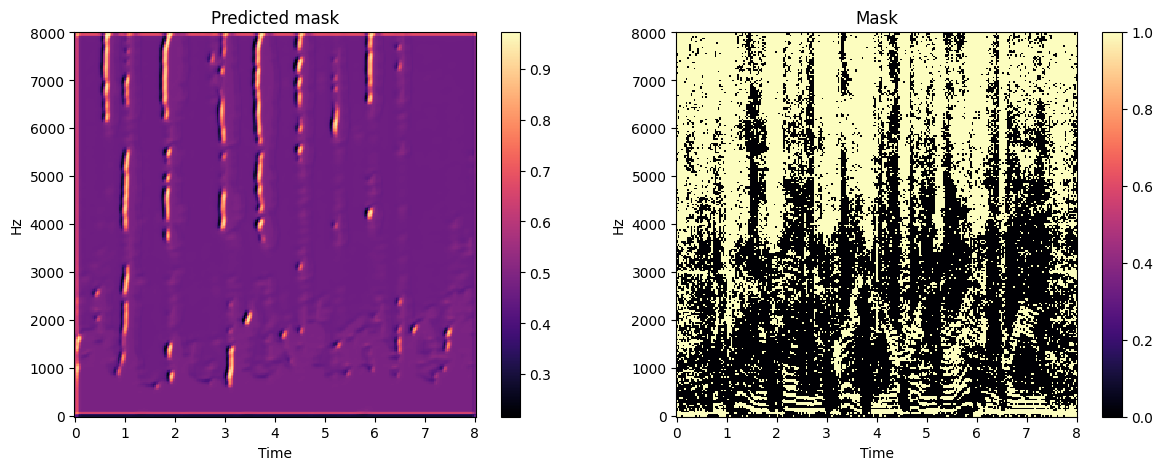

In [ ]:
# plot predicted mask
plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(predicted_mask[0][0], sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Predicted mask")

# plot mask
plt.subplot(1, 3, 2)
librosa.display.specshow(mask, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Mask")